# <center>Predicting the Traffic Flow in Toronto
## <center>DS3000 - Intro to Machine Learning - Final Project
### <center>Group 5
### <center>Alexis Litt, Branka Verhoeven, Serah Quinn, Andrii Prykhodko, Andrew Bliss

The following is the code which will take historic data at a given intersection and use it to predict traffic flow volumes at any given time:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.layers import Input

## Random Forest Implementation

In [105]:

# modify this if u need
#df = pd.read_csv('/content/drive/MyDrive/DS 3000/FinalProject/RawTrafficData.csv')
df = pd.read_csv('RawTrafficData.csv')

# Drop rows where traffic_source is not 'Toronto'
df = df[df['traffic_source'] == 'Toronto']

street1 = 'ADELAIDE'
street2 = 'PARLIAMENT'

# Function to process data for a given street or combination LOOK FOR USE CASE BELOW
def process_street_data(df, street_filter):
    filtered_df = df[df['camera_road'].str.contains(street_filter, case=False, na=False)]

    # Calculate the percentage of missing values in each row for date columns
    date_cols = [col for col in filtered_df.columns if col.startswith('x')]
    filtered_df['missing_percentage'] = filtered_df[date_cols].isnull().sum(axis=1) / len(date_cols)

    # Remove rows with 60% or more missing values in date columns
    filtered_df = filtered_df[filtered_df['missing_percentage'] < 0.6]

 # to remove outliers
    Q1 = filtered_df[date_cols].stack().quantile(0.25)  # 25th percentile
    Q3 = filtered_df[date_cols].stack().quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

    # Remove both lower and upper outliers
    filtered_df = filtered_df[
        (filtered_df[date_cols] >= lower_bound).any(axis=1) &
        (filtered_df[date_cols] <= upper_bound).any(axis=1)
    ]

    # Drop the first 5 columns (metadata columns)
    filtered_df = filtered_df.drop(filtered_df.columns[:5], axis=1)

    # Calculate the sum of each date column
    date_sums = filtered_df[date_cols].sum(axis=0)

    # Create a new DataFrame with the date column sums
    traffic_data = pd.DataFrame({'Traffic day': date_cols, 'Traffic count': date_sums})

    # Impute missing values in the 'Traffic count' column in traffic_data
    imputer = SimpleImputer(strategy='mean')
    traffic_data['Traffic count'] = imputer.fit_transform(traffic_data[['Traffic count']])

    # Convert 'Traffic day' to datetime format
    traffic_data['Traffic day'] = pd.to_datetime(traffic_data['Traffic day'].str[1:], format='%Y_%m_%d')

    # Extract day of the week, numeric month, and day of the month
    traffic_data['day_of_week'] = traffic_data['Traffic day'].dt.dayofweek
    traffic_data['month'] = traffic_data['Traffic day'].dt.month
    traffic_data['day_of_month'] = traffic_data['Traffic day'].dt.day

    # Reorder the columns
    traffic_data = traffic_data[['Traffic day', 'day_of_week', 'month', 'day_of_month', 'Traffic count']]

    # Drop rows where 'Traffic count' equals 0
    traffic_data = traffic_data[traffic_data['Traffic count'] != 0]

    # Set 'Traffic day' as the index
    traffic_data.set_index('Traffic day', inplace=True)

    return traffic_data



# Process data for ADELAIDE
'''

single street call

'''
adelaide_data = process_street_data(df, street1)

# Process data for PARLIAMENT
parliament_data = process_street_data(df, street2)

# Process data for ADELAIDE and PARLIAMENT intersection
'''
SYNTAX for intersection:

.* : Matches any number of characters (including none) between street1 and street2
|  : An OR condition, meaning it will match either street1 followed by street2 or street2 followed by street1

'''
intersection_data = process_street_data(df, f"{street1}.*{street2}|{street2}.*{street1}")

# Display results
print("ADELAIDE Data")
print(adelaide_data.head())

print("\nPARLIAMENT Data")
print(parliament_data.head())

print("\nIntersection Data")
print(intersection_data.head())

# Outputs are stored in adelaide_data, parliament_data, and intersection_data DataFrames.

ADELAIDE Data
             day_of_week  month  day_of_month  Traffic count
Traffic day                                                 
2022-02-03             3      2             3          538.0
2022-02-04             4      2             4          867.0
2022-02-05             5      2             5          565.0
2022-02-06             6      2             6          556.0
2022-02-07             0      2             7          745.0

PARLIAMENT Data
             day_of_week  month  day_of_month  Traffic count
Traffic day                                                 
2022-02-03             3      2             3          884.0
2022-02-04             4      2             4         1578.0
2022-02-05             5      2             5          856.0
2022-02-06             6      2             6          956.0
2022-02-07             0      2             7         1435.0

Intersection Data
             day_of_week  month  day_of_month  Traffic count
Traffic day                        

<ipython-input-105-47b5b12776ca>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['missing_percentage'] = filtered_df[date_cols].isnull().sum(axis=1) / len(date_cols)
<ipython-input-105-47b5b12776ca>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['missing_percentage'] = filtered_df[date_cols].isnull().sum(axis=1) / len(date_cols)
<ipython-input-105-47b5b12776ca>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [102]:
def visualize_traffic_data(adelaide_data, parliament_data, intersection_data):

    plt.figure(figsize=(18, 25))

    # Time-series plot for all three datasets
    plt.subplot(4, 1, 1)
    plt.plot(adelaide_data.index, adelaide_data['Traffic count'], label='Adelaide', color='blue')
    plt.plot(parliament_data.index, parliament_data['Traffic count'], label='Parliament', color='green')
    plt.plot(intersection_data.index, intersection_data['Traffic count'], label='Intersection', color='red')
    plt.title('Traffic Count Over Time')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()

    # Box plot for Adelaide
    plt.subplot(4, 1, 2)
    sns.boxplot(data=adelaide_data, x='day_of_week', y='Traffic count', palette='Blues')
    plt.title('Traffic Count by Day of Week - Adelaide')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Traffic Count')

    # Box plot for Parliament
    plt.subplot(4, 1, 3)
    sns.boxplot(data=parliament_data, x='day_of_week', y='Traffic count', palette='Greens')
    plt.title('Traffic Count by Day of Week - Parliament')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Traffic Count')

    # Box plot for Intersection
    plt.subplot(4, 1, 4)
    sns.boxplot(data=intersection_data, x='day_of_week', y='Traffic count', palette='Reds')
    plt.title('Traffic Count by Day of Week - Intersection')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Traffic Count')

    plt.tight_layout()
    plt.show()

    # Pie chart for traffic distribution (separate figure)
    plt.figure(figsize=(8, 8))
    total_adelaide = adelaide_data['Traffic count'].sum()
    total_parliament = parliament_data['Traffic count'].sum()
    #total_intersection = intersection_data['Traffic count'].sum()
    ratios = [total_adelaide, total_parliament]
    labels = ['Adelaide', 'Parliament', ]
    plt.pie(ratios, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Traffic Distribution Across Datasets')
    plt.show()

In [90]:
def decompose_time_series(data, period=7):
    """
    Decomposes time-series data into observed, trend, seasonal, and residual components.

        period : Seasonal period for decomposition (default is weekly, period=7).

    """
    # Remove NaN values for decomposition
    clean_data = data['Traffic count'].dropna()

    try:
        # Perform seasonal decomposition
        result = seasonal_decompose(clean_data, period=period)

        # Plot decomposition components
        plt.figure(figsize=(15, 12))
        plt.suptitle('Time Series Decomposition')

        plt.subplot(4, 1, 1)
        plt.plot(result.observed, label='Observed')
        plt.title('Observed Traffic Count')
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(result.trend, label='Trend', color='orange')
        plt.title('Trend')
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(result.seasonal, label='Seasonal', color='green')
        plt.title(f'Seasonal (Period = {period})')
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(result.resid, label='Residuals', color='red')
        plt.title('Residuals')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Decomposition failed: {e}")
        print("Ensure the dataset has sufficient data for the specified period.")

In [75]:
def prepare_ml_features(data, lag_features=3, include_ratios=False, ratios=None):
    """
    Prepares features for machine learning, including lag features and temporal attributes.
        data : Data containing 'Traffic count' and temporal features.
        lag_features : Number of lag features to create.
        include_ratios : Whether to include traffic ratios as features.   |Don't know if want these(not complete)
        ratios : Initial traffic ratios for two streets (default is None).|

    Returns:
        X : Feature matrix.
        y : Target variable (Traffic count).
    """
    # Create lag features
    for i in range(1, lag_features + 1):
        data[f'traffic_lag_{i}'] = data['Traffic count'].shift(i)

    # Add traffic ratios if applicable
    if include_ratios and ratios:
        street1_ratio, street2_ratio = ratios
        data['traffic_ratio_street1'] = street1_ratio
        data['traffic_ratio_street2'] = street2_ratio

    # Drop rows with NaN values (introduced by lag features)
    ml_data = data.dropna()

    # Prepare feature list
    features = [f'traffic_lag_{i}' for i in range(1, lag_features + 1)] + \
               ['day_of_week', 'month', 'day_of_month']
    if include_ratios:
        features += ['traffic_ratio_street1', 'traffic_ratio_street2']

    # Extract features and target
    X = ml_data[features]
    y = ml_data['Traffic count']

    return X, y

In [91]:
def train_and_evaluate_rf_model(X, y, test_size=0.3, n_estimators=100, random_state=42):
    """
    Trains and evaluates a Random Forest Regressor model on traffic data.
        X : Feature set.
        y : Target variable (Traffic count).
        test_size : Proportion of data to use for testing (default 0.3).
        n_estimators : Number of estimators for the Random Forest (default 100).
        random_state : Random state for reproducibility (default 42).

    Returns:
        dict: Evaluation metrics (MAE, RMSE, R²).
        RandomForestRegressor: Trained model.
        MinMaxScaler: Scaler used for the features.
        tuple: Scaled training and testing sets (X_train_scaled, X_test_scaled, y_train, y_test).
    """
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    # Scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train_scaled, y_train)

    # Making predictions using the model
    y_pred = rf_model.predict(X_test_scaled)

    # Defining model evaluation metrics
    rf_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    # Plotting actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)
    plt.title('Actual vs Predicted Traffic Count')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rf_metrics, rf_model, scaler, (X_train_scaled, X_test_scaled, y_train, y_test)

In [112]:
# Predict future periods for all datasets
def predict_future_periods_for_all(models, scalers, datasets, periods=7, include_ratios=False, ratios=None):
    """
    Predicts future traffic counts for multiple datasets using corresponding models and scalers.

        models: Dictionary containing trained models for each dataset (keys: 'Adelaide', 'Parliament', 'Intersection').
        scalers: Dictionary containing scalers used to normalize the feature sets for each dataset.
        datasets: Dictionary containing feature sets for each dataset (keys are dataset names, values are feature sets).
        periods: Number of future periods to predict.
        include_ratios: Whether to include traffic ratios in predictions.
        ratios: Initial traffic ratios for two streets (default is None).

    Returns:
        dict: Predicted traffic counts for each dataset as a dictionary of pd.Series.
    """
    predictions_all = {}

    for dataset_name, X in datasets.items():
        model = models[dataset_name]
        scaler = scalers[dataset_name]

        # Use predict_future_periods to get predictions for each dataset
        predictions = predict_future_periods(
            model=model,
            scaler=scaler,
            X=X,
            periods=periods,
            include_ratios=include_ratios,
            ratios=ratios
        )
        predictions_all[dataset_name] = predictions

    return predictions_all


<ipython-input-102-198bd1e1a704>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=adelaide_data, x='day_of_week', y='Traffic count', palette='Blues')
<ipython-input-102-198bd1e1a704>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=parliament_data, x='day_of_week', y='Traffic count', palette='Greens')
<ipython-input-102-198bd1e1a704>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=intersection_data, x='day_of_week', y='Traffic count', palette='Reds')


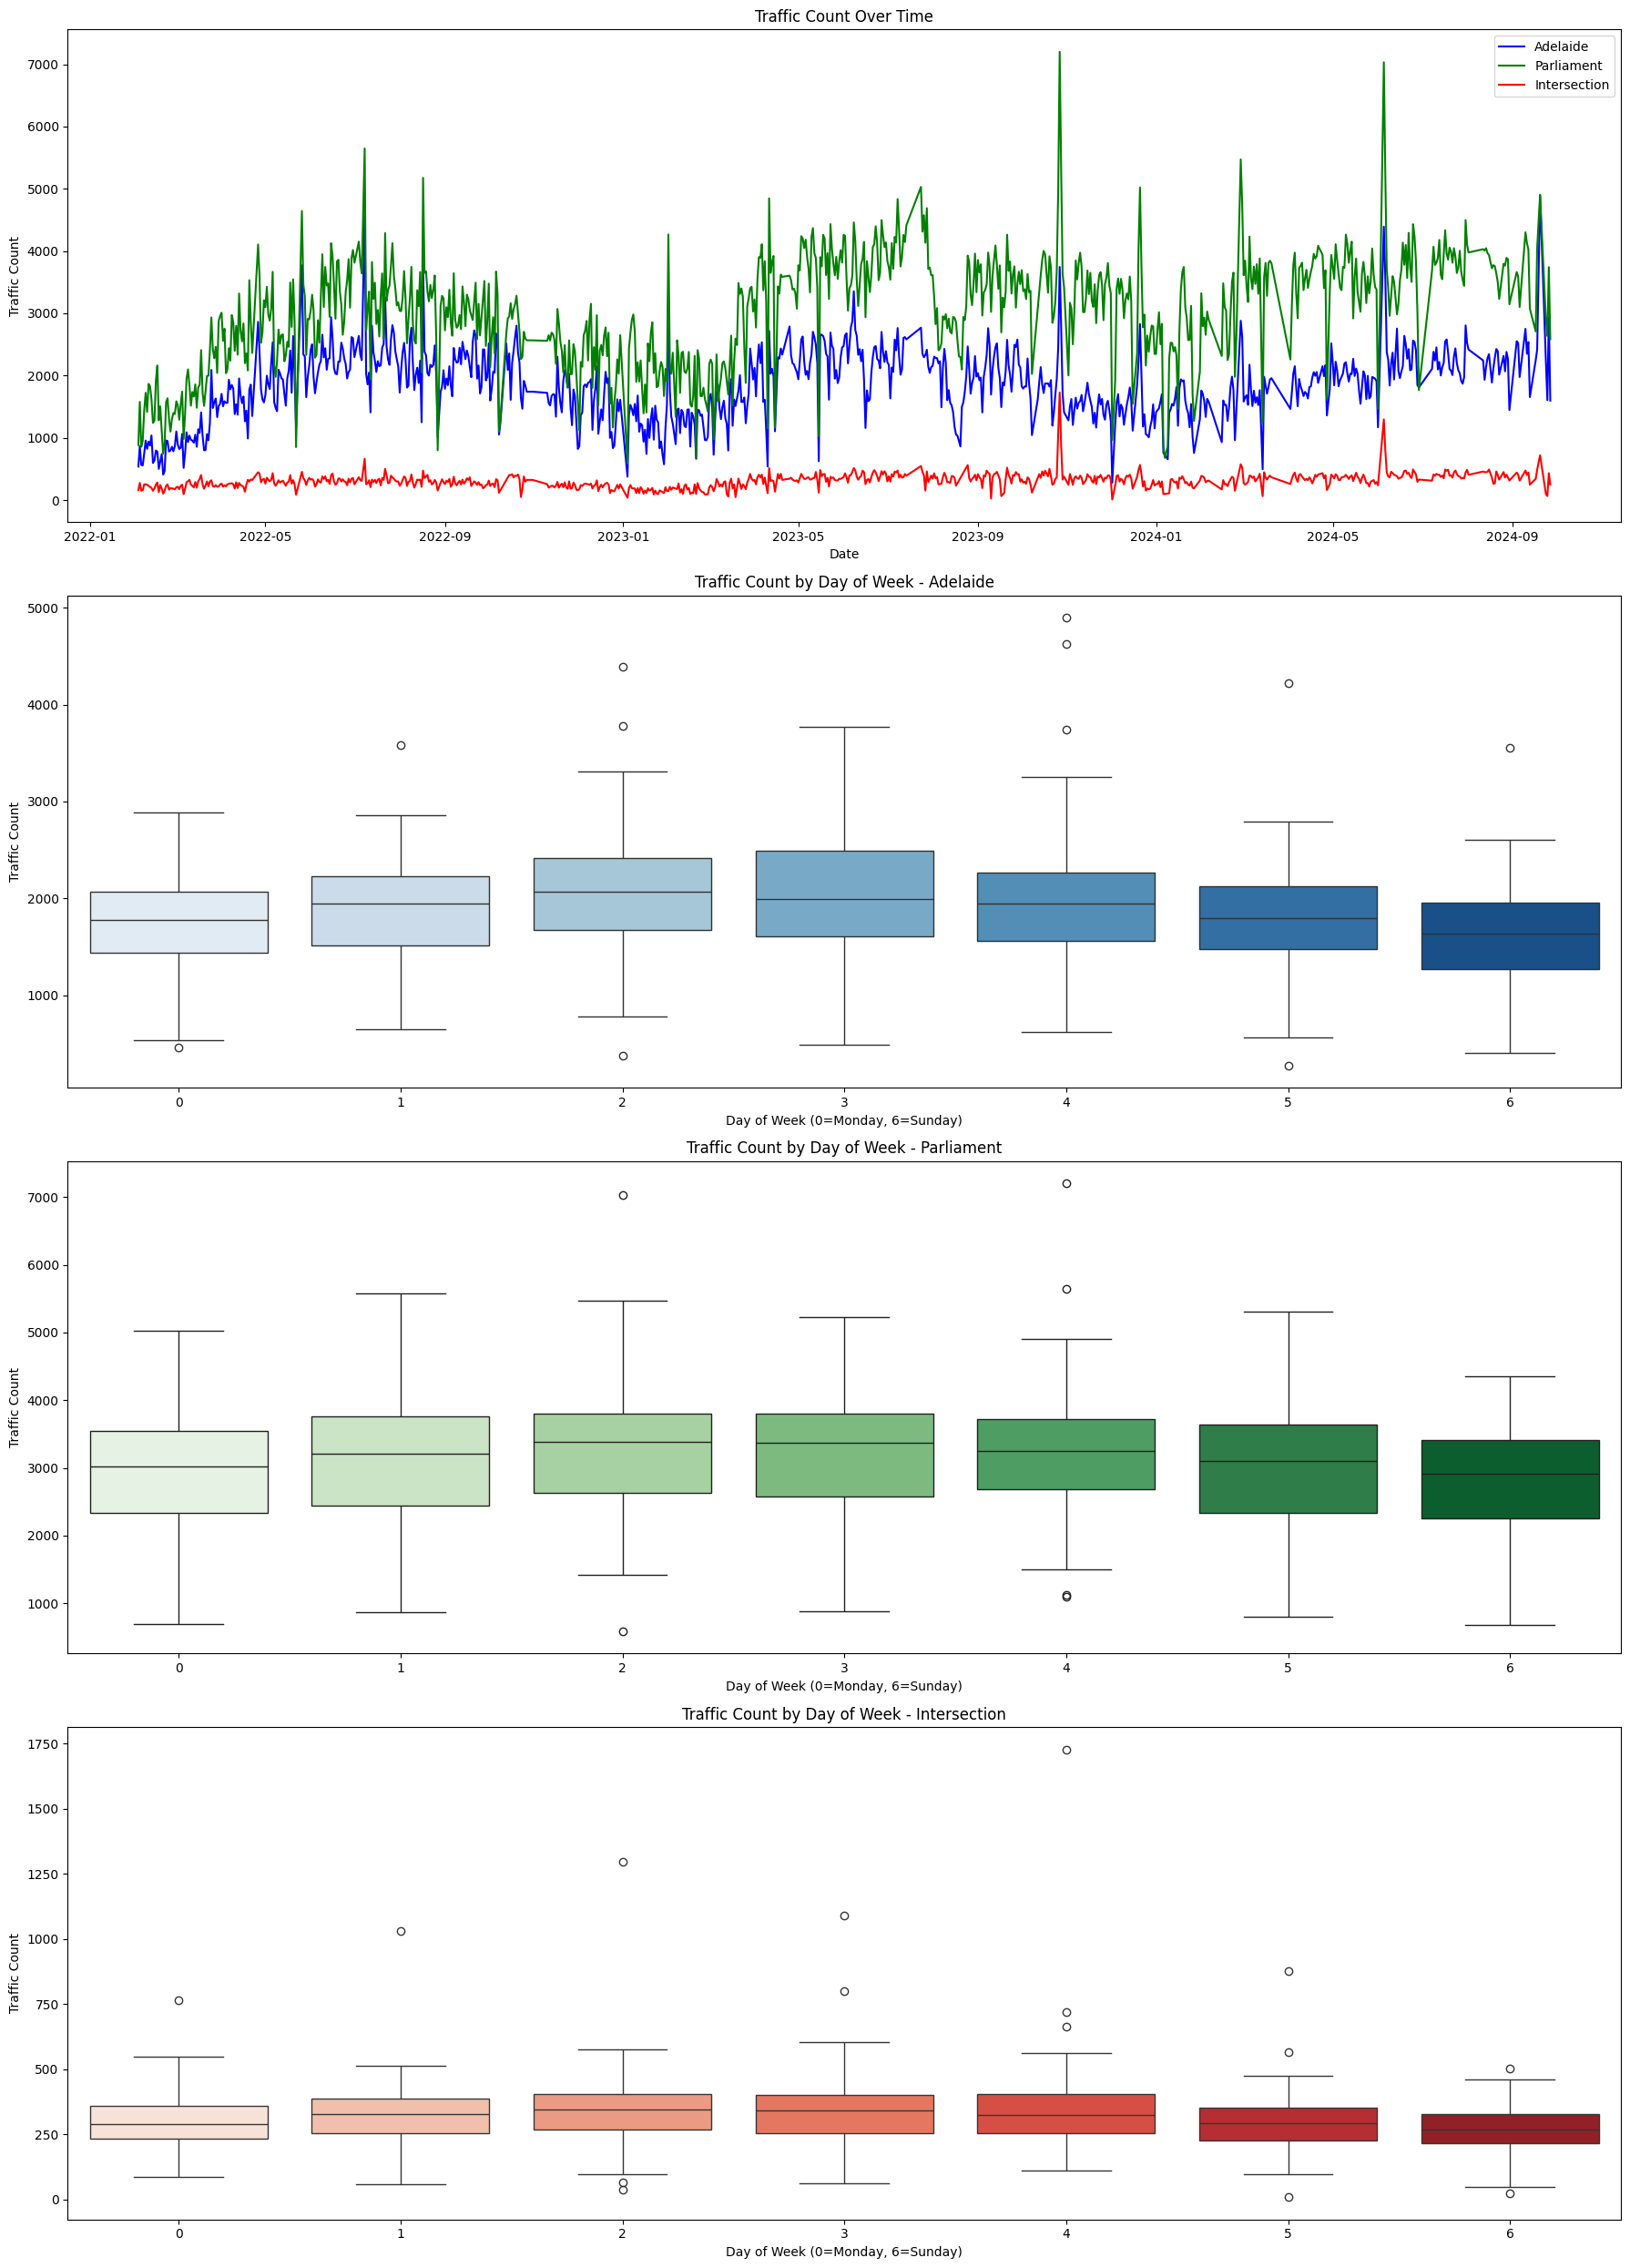

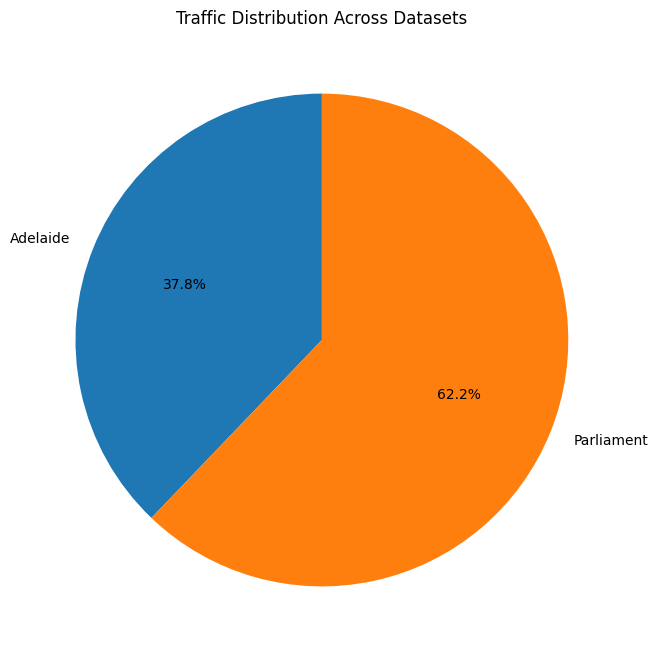

In [103]:
#visualizing the data
visualize_traffic_data(adelaide_data, parliament_data, intersection_data)

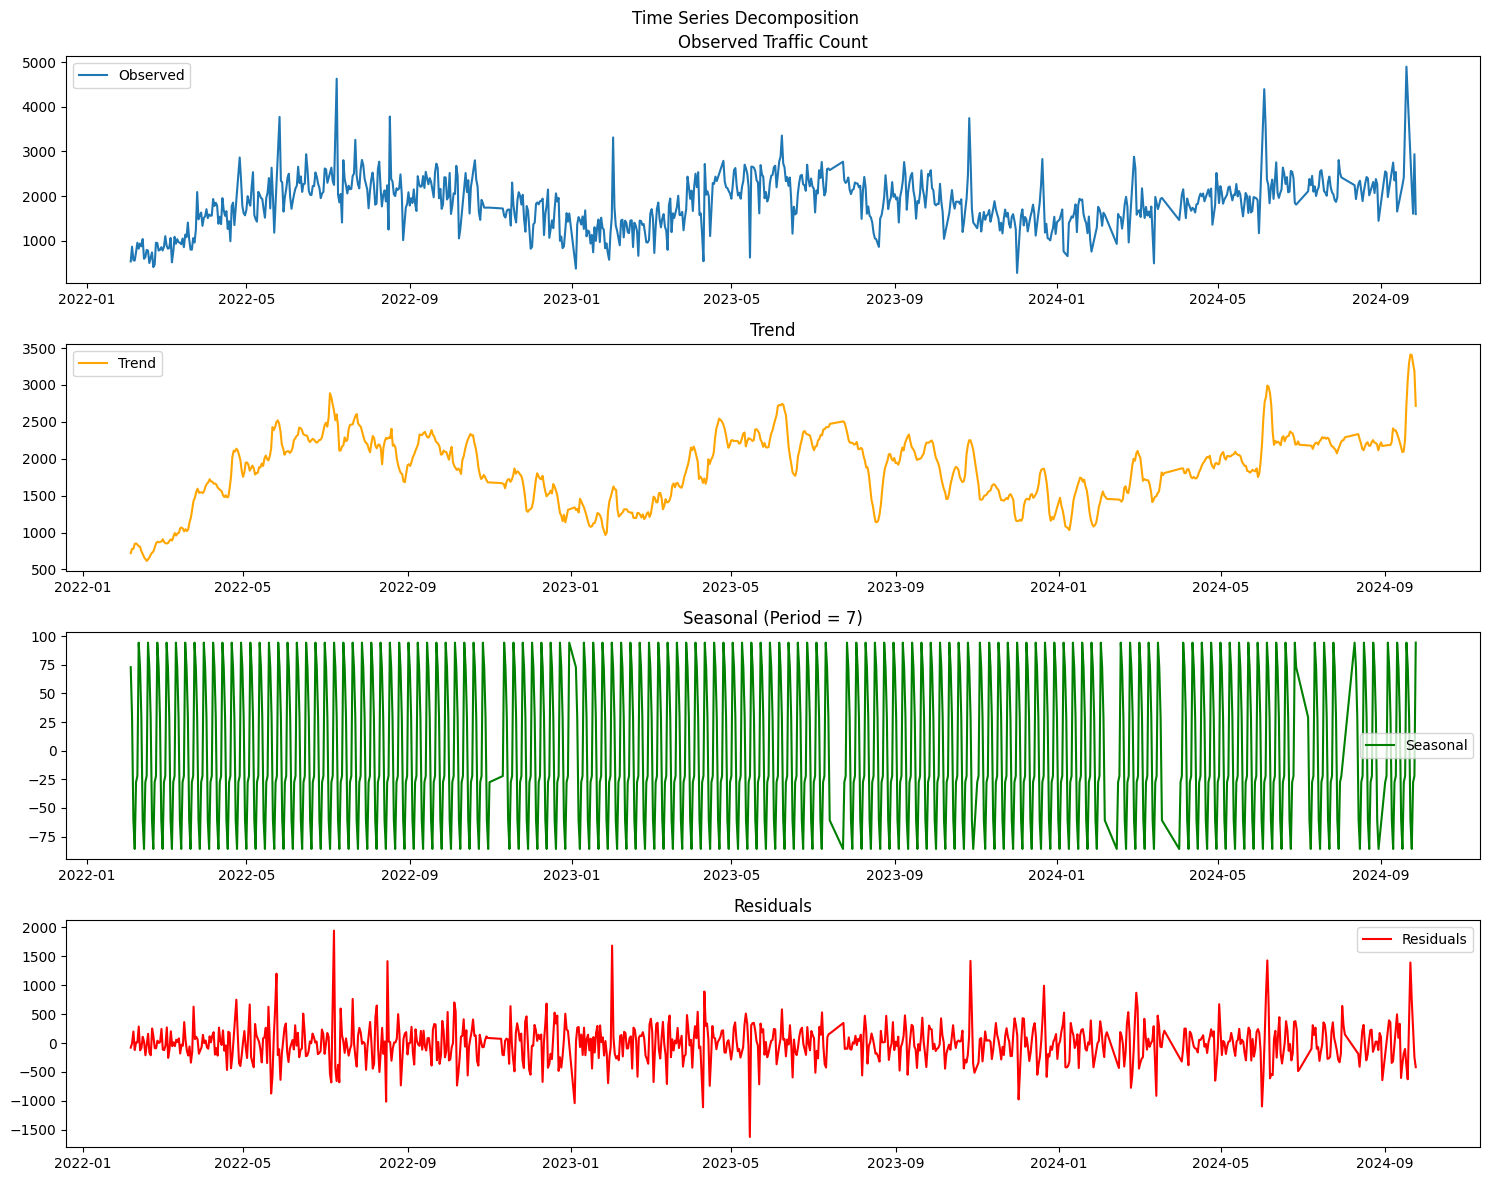

In [66]:
#performing the time series decomposition
decompose_time_series(traffic_data)

Training model for Adelaide...


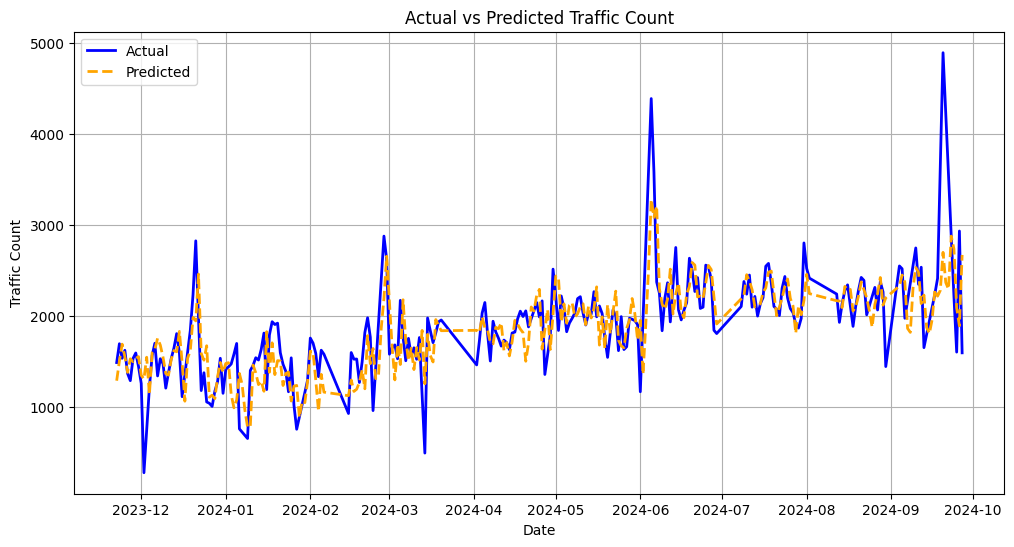

Evaluation Metrics for Adelaide: {'MAE': 267.6466296296296, 'RMSE': 394.0435564977651, 'R2': 0.5345084331919545}
Training model for Parliament...


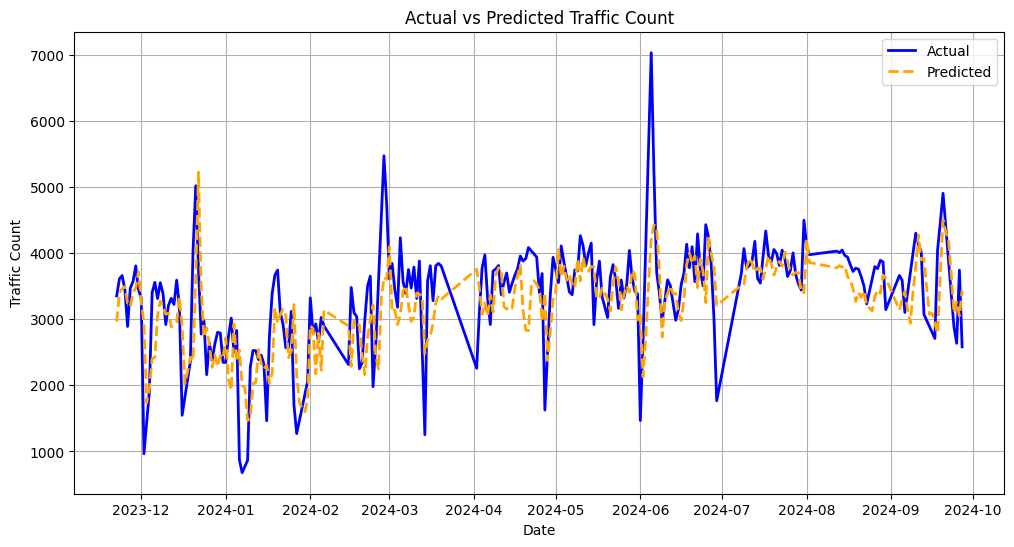

Evaluation Metrics for Parliament: {'MAE': 475.5538518518519, 'RMSE': 644.064673891959, 'R2': 0.390461327929042}
Training model for Intersection...


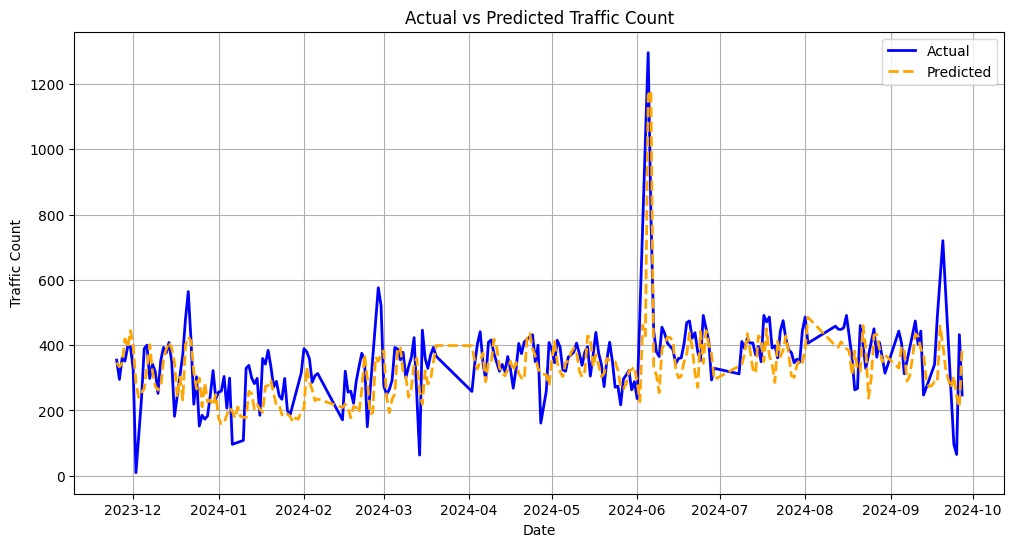

Evaluation Metrics for Intersection: {'MAE': 73.44973782771537, 'RMSE': 99.63066051851611, 'R2': 0.37513037774470204}

Future Predictions for Adelaide:
2024-09-28    2673.06
2024-09-29    1936.59
2024-09-30    1835.81
2024-10-01     911.95
2024-10-02    1482.00
2024-10-03    2120.77
2024-10-04    2171.35
Freq: D, dtype: float64


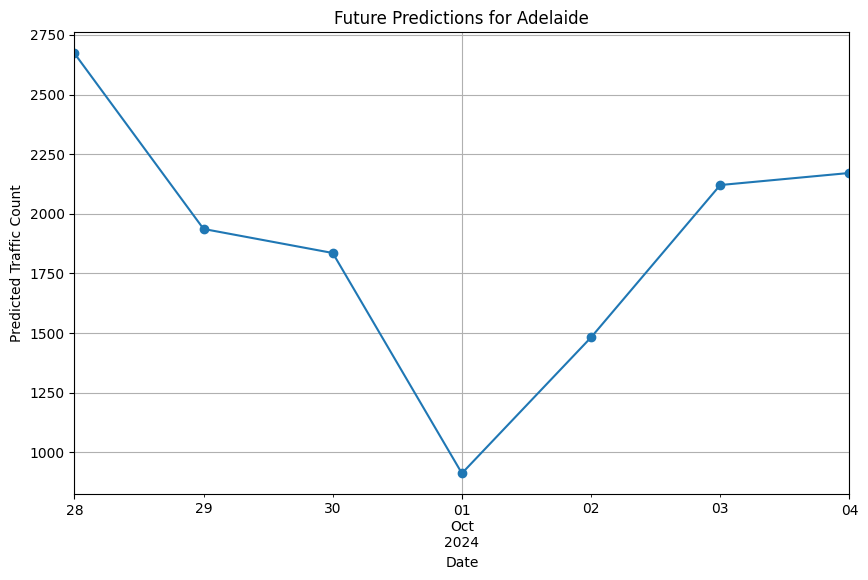


Future Predictions for Parliament:
2024-09-28    3437.49
2024-09-29    2331.00
2024-09-30    2490.95
2024-10-01    1718.90
2024-10-02    1759.07
2024-10-03    2045.08
2024-10-04    2572.43
Freq: D, dtype: float64


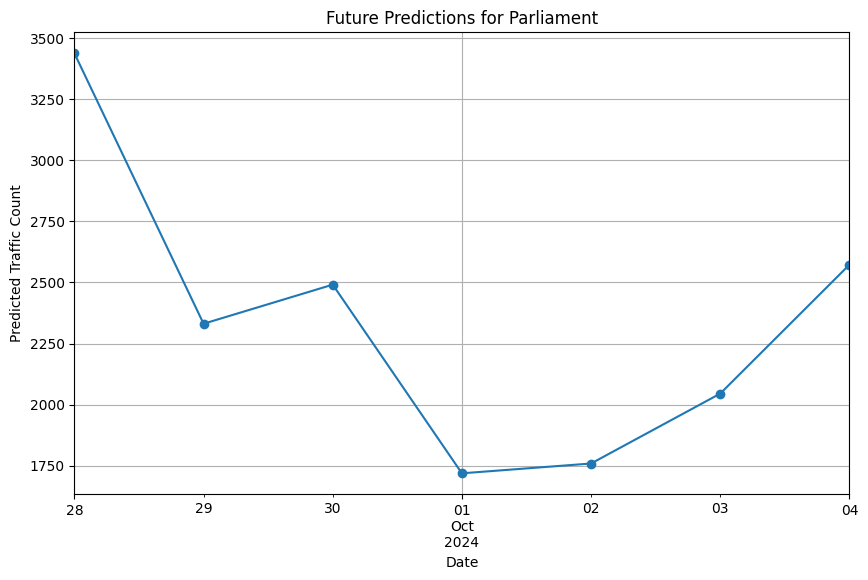


Future Predictions for Intersection:
2024-09-28    394.49
2024-09-29    194.78
2024-09-30    202.40
2024-10-01    201.82
2024-10-02    224.43
2024-10-03    200.29
2024-10-04    338.96
Freq: D, dtype: float64


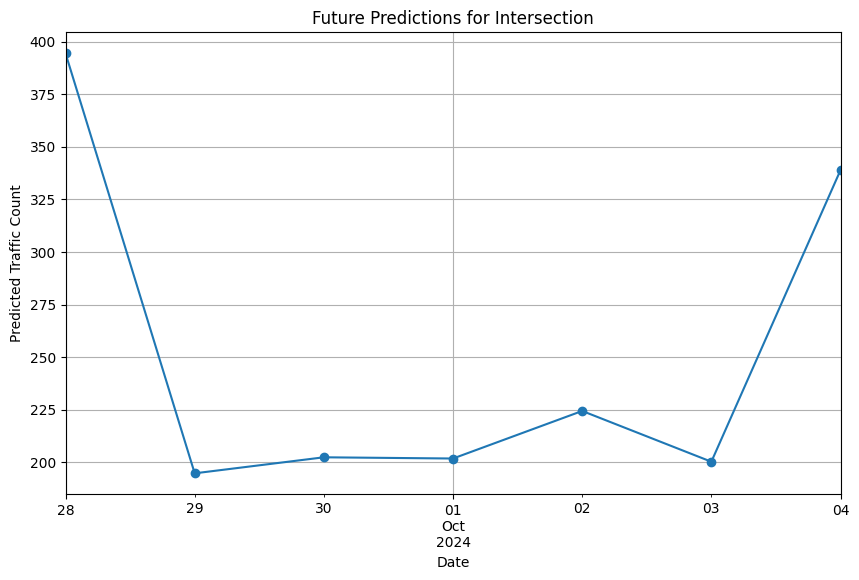

In [113]:
# Prepare features and target variables for each dataset
datasets = {
    'Adelaide': adelaide_data,
    'Parliament': parliament_data,
    'Intersection': intersection_data
}

prepared_data = {}
for name, data in datasets.items():
    X, y = prepare_ml_features(data, lag_features=3, include_ratios=False)  # Adjust lag/ration options if needed
    prepared_data[name] = (X, y)

# Train and evaluate models for each dataset
models = {}
scalers = {}
results = {}
scaled_data = {}

for name, (X, y) in prepared_data.items():
    print(f"Training model for {name}...")
    metrics, model, scaler, scaled_sets = train_and_evaluate_rf_model(X, y)
    models[name] = model
    scalers[name] = scaler
    results[name] = metrics
    scaled_data[name] = scaled_sets  # Stores scaled train/test data
    print(f"Evaluation Metrics for {name}: {metrics}")

# Call the prediction function
future_predictions = predict_future_periods_for_all(
    models=models,
    scalers=scalers,
    datasets={name: data[0] for name, data in prepared_data.items()},  # Pass feature sets
    periods=7  # Predict for the next 7 days
)

# Visualize future predictions
for dataset_name, predictions in future_predictions.items():
    print(f"\nFuture Predictions for {dataset_name}:")
    print(predictions)

    # Plot future predictions
    predictions.plot(figsize=(10, 6), marker='o', title=f'Future Predictions for {dataset_name}')
    plt.xlabel('Date')
    plt.ylabel('Predicted Traffic Count')
    plt.grid(True)
    plt.show()

In [67]:
initial_ratios = (0.6, 0.4)  # Example traffic ratios for Adelaide and Parliament
X, y = prepare_ml_features(traffic_data, lag_features=3, include_ratios=True, ratios=initial_ratios)

## Convolutional Neural Network Implementation

In [12]:
#preparing the data for CNN
def prepare_cnn_data(X, y):
    #CNN needs a 3D input: (samples, time steps, features)
    X_reshaped = X.values.reshape(X.shape[0], X.shape[1], 1)
    return X_reshaped, y

In [13]:
#preprocessing the data for cnn by splitting it into the 80/20 test split and scaling it
def preprocess_data_for_cnn(X, y):

    #splitting training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    #scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #reshaping the data for CNN
    X_train_cnn, y_train_cnn = prepare_cnn_data(pd.DataFrame(X_train_scaled), y_train)
    X_test_cnn, y_test_cnn = prepare_cnn_data(pd.DataFrame(X_test_scaled), y_test)

    return X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, scaler

In [14]:
#building the CNN model
def build_cnn_model(input_shape):

    model = Sequential([
        Input(shape=input_shape),  # Explicit input layer
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)  # Single output for regression
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [15]:
#training the CNN model
#small datasets recommend batch size of 8, 16, 32, Epochs should be 10-30, learning rate 0.001 (adam)
def train_cnn_model(X_train, y_train, X_val, y_val, input_shape, epochs=30, batch_size=16):

    model = build_cnn_model(input_shape)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size, verbose=2)
    return model

In [16]:
#evaluating the CNN model
def evaluate_model(model, X_test, y_test, visualize):

    #making predictions
    y_pred = model.predict(X_test).flatten()

    #evaluating metrics
    CNN_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    if vizualize == 1:
        #plotting predictions
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.index, y_test.values, label='Actual')
        plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
        plt.title('Actual vs Predicted Traffic Count')
        plt.xlabel('Date')
        plt.ylabel('Traffic Count')
        plt.legend()
        plt.show()

    return CNN_metrics


In [17]:
#preprocessing the data for CNN
X_train, X_test, y_train, y_test, scaler = preprocess_data_for_cnn(X, y)

In [18]:
#training the CNN model
input_shape = (X_train.shape[1], X_train.shape[2])
cnn_model = train_cnn_model(X_train, y_train, X_test, y_test, input_shape, epochs=50)

Epoch 1/50
45/45 - 2s - 50ms/step - loss: 3524914.5000 - mae: 1785.2776 - val_loss: 4675701.5000 - val_mae: 2099.6289
Epoch 2/50
45/45 - 0s - 7ms/step - loss: 2913922.0000 - mae: 1601.6665 - val_loss: 2677666.0000 - val_mae: 1556.3088
Epoch 3/50
45/45 - 0s - 4ms/step - loss: 717496.3750 - mae: 667.4289 - val_loss: 295051.8438 - val_mae: 394.6249
Epoch 4/50
45/45 - 0s - 4ms/step - loss: 314148.0312 - mae: 443.2826 - val_loss: 380635.5938 - val_mae: 454.8319
Epoch 5/50
45/45 - 0s - 6ms/step - loss: 308884.2812 - mae: 437.4885 - val_loss: 343321.1875 - val_mae: 425.8009
Epoch 6/50
45/45 - 0s - 4ms/step - loss: 307752.3125 - mae: 435.8551 - val_loss: 338592.5312 - val_mae: 421.4260
Epoch 7/50
45/45 - 0s - 3ms/step - loss: 304200.3750 - mae: 434.0531 - val_loss: 369587.0000 - val_mae: 444.4948
Epoch 8/50
45/45 - 0s - 3ms/step - loss: 298317.7188 - mae: 432.0093 - val_loss: 329480.5625 - val_mae: 413.0365
Epoch 9/50
45/45 - 0s - 4ms/step - loss: 289814.5000 - mae: 424.6401 - val_loss: 339216

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


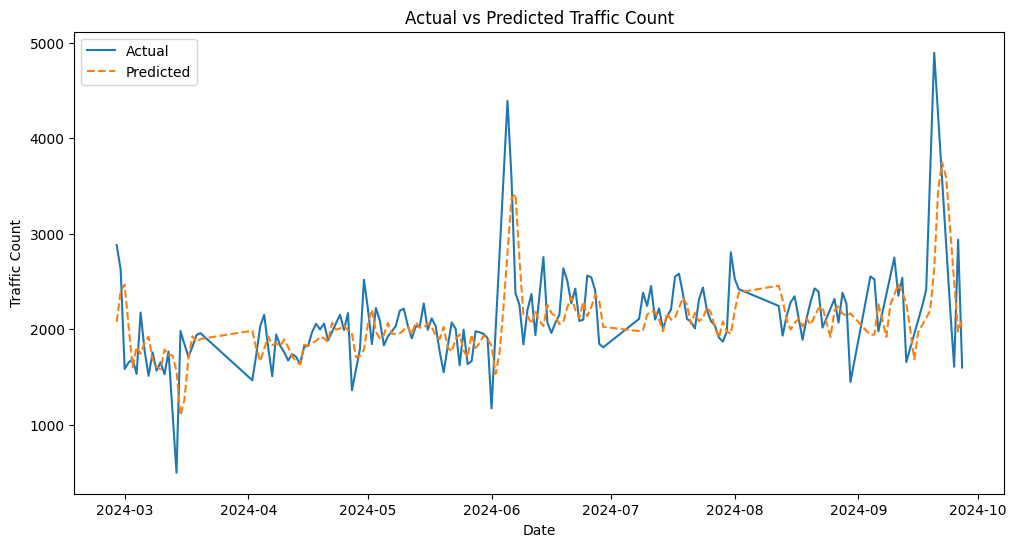

CNN Model Performance Metrics:
MAE: 281.4393263075087
RMSE: 427.94363434825
R2: 0.31748469644843735


In [ ]:
#evaluating the model
vizualize = 1
CNN_metrics = evaluate_model(cnn_model, X_test, y_test, vizualize)
print("CNN Model Performance Metrics:")
for metric, value in CNN_metrics.items():
    print(f"{metric}: {value}")

## Comparing the metrics to determine the best model

Random Forest Model Performance Metrics:
MAE: 267.6466296296296
RMSE: 394.0435564977651
R2: 0.5345084331919545
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

CNN Model Performance Metrics:
MAE: 281.4393263075087
RMSE: 427.94363434825
R2: 0.31748469644843735


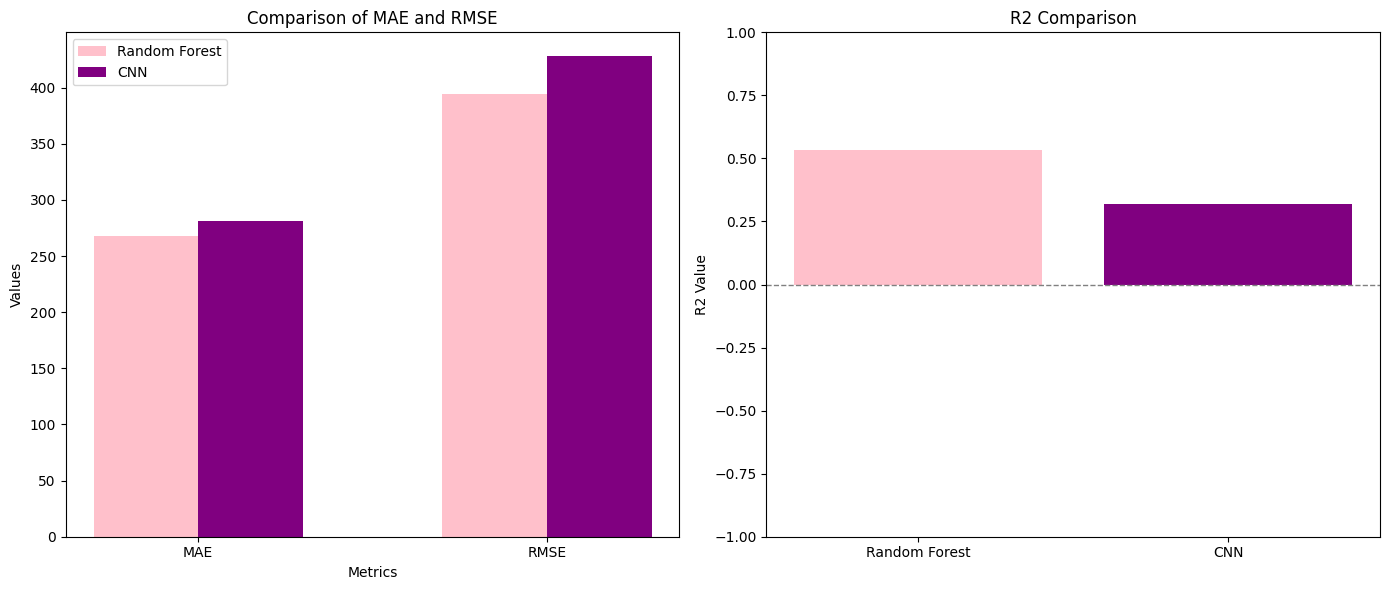


The Random Forest model outperforms the CNN model based on the metrics.


In [ ]:
# Evaluating Random Forest model again
print("Random Forest Model Performance Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

# Evaluating CNN model
vizualize = 0
cnn_metrics = evaluate_model(cnn_model, X_test, y_test, vizualize)
print("\nCNN Model Performance Metrics:")
for metric, value in cnn_metrics.items():
    print(f"{metric}: {value}")

# Extracting metrics for comparison
metrics_names = ['MAE', 'RMSE']
rf_values = [rf_metrics[metric] for metric in metrics_names]
cnn_values = [cnn_metrics[metric] for metric in metrics_names]
rf_r2 = rf_metrics['R2']
cnn_r2 = cnn_metrics['R2']

# Setting up a bar graph for MAE and RMSE
x = np.arange(len(metrics_names))  # The label locations
width = 0.3  # The width of the bars

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for MAE and RMSE
axs[0].bar(x - width / 2, rf_values, width, label='Random Forest', color='pink')
axs[0].bar(x + width / 2, cnn_values, width, label='CNN', color='purple')

# Adding labels, a title, and a legend to the first subplot
axs[0].set_xlabel('Metrics')
axs[0].set_ylabel('Values')
axs[0].set_title('Comparison of MAE and RMSE')
axs[0].set_xticks(x)
axs[0].set_xticklabels(metrics_names)
axs[0].legend()

# Bar chart for R2 with scale and horizontal line at 0
r2_models = ['Random Forest', 'CNN']
r2_values = [rf_r2, cnn_r2]
axs[1].bar(r2_models, r2_values, color=['pink', 'purple'])

# Adding labels, a title, and scale to the second subplot
axs[1].set_ylabel('R2 Value')
axs[1].set_title('R2 Comparison')
axs[1].set_ylim(-1, 1)  # Setting the scale from -1 to 1
axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)  # Horizontal line at 0

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Comparing the metrics and deciding the best model
if cnn_metrics['MAE'] < rf_metrics['MAE'] and cnn_metrics['RMSE'] < rf_metrics['RMSE'] and cnn_metrics['R2'] > rf_metrics['R2']:
    print("\nThe CNN model outperforms the Random Forest model based on the metrics.")
else:
    print("\nThe Random Forest model outperforms the CNN model based on the metrics.")
